In [1]:
import argparse
import pathlib
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as scind
import scipy.sparse
from centrosome.filter import stretch
from scipy.fftpack import fft2, ifft2
from skimage import io, registration, transform

sys.path.append("../alignment_utils")
from alignment_utils import align_cross_correlation, apply_alignment

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")
    parser.add_argument(
        "--final_timepoint_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--terminal_timepoint_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    args = parser.parse_args()
    final_timepoint_dir = pathlib.Path(args.final_timepoint_dir).resolve(strict=True)
    terminal_timepoint_dir = pathlib.Path(args.terminal_timepoint_dir).resolve(
        strict=True
    )


else:
    final_timepoint_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001"
    ).resolve(strict=True)
    terminal_timepoint_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-02_F0001"
    ).resolve(strict=True)

well_fov = final_timepoint_dir.name
well_fov = well_fov.split("_")[4] + "_" + well_fov.split("_")[5]

In [3]:
final_timepoint_dna_path = pathlib.Path(
    final_timepoint_dir / f"{well_fov}_T0013_Z0001_C01_illumcorrect.tiff"
).resolve(strict=True)


terminal_timepoint_dna_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C01_illumcorrect.tiff"
).resolve(strict=True)

terminal_timepoint_annexin_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C05_illumcorrect.tiff"
).resolve(strict=True)

terminal_timepoint_nuclei_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_nuclei_mask.tiff"
).resolve(strict=True)

terminal_timepoint_cell_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_cell_mask.tiff"
).resolve(strict=True)

final_timepoint_dna = io.imread(str(final_timepoint_dna_path))
terminal_timepoint_dna = io.imread(str(terminal_timepoint_dna_path))
terminal_timepoint_annexin = io.imread(str(terminal_timepoint_annexin_path))
terminal_timepoint_nuclei_mask = io.imread(str(terminal_timepoint_nuclei_mask_path))
terminal_timepoint_cell_mask = io.imread(str(terminal_timepoint_cell_mask_path))

Align the dna stained images bewteen the two timepoints and apply the same transformation to all terminal images

In [4]:
# get offsets
offsets = align_cross_correlation(
    pixels1=final_timepoint_dna,
    pixels2=terminal_timepoint_dna,
)
print("Offsets: ", offsets)

Offsets:  (-180, -5)


/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/3c.segment_cells/notebooks/../alignment_utils/alignment_utils.py:209: RuntimeWarning: divide by zero encountered in divide
  corrnorm = corr12 / sd
/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/3c.segment_cells/notebooks/../alignment_utils/alignment_utils.py:209: RuntimeWarning: invalid value encountered in divide
  corrnorm = corr12 / sd


In [5]:
# apply the offsets
aligned_terminal_timepoint_dna = apply_alignment(
    input_image=terminal_timepoint_dna,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_dna.shape,
)
aligned_terminal_timepoint_annexin = apply_alignment(
    input_image=terminal_timepoint_annexin,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_annexin.shape,
)
aligned_terminal_timepoint_nuclei_mask = apply_alignment(
    input_image=terminal_timepoint_nuclei_mask,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_nuclei_mask.shape,
)
aligned_terminal_timepoint_cell_mask = apply_alignment(
    input_image=terminal_timepoint_cell_mask,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_cell_mask.shape,
)

In [6]:
# save the aligned images
aligned_terminal_timepoint_dna_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C01_illumcorrect_aligned.tiff"
).resolve()
aligned_terminal_timepoint_annexin_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C05_illumcorrect_aligned.tiff"
).resolve()
aligned_terminal_timepoint_nuclei_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_nuclei_mask_aligned.tiff"
).resolve()
aligned_terminal_timepoint_cell_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_cell_mask_aligned.tiff"
).resolve()


io.imsave(str(aligned_terminal_timepoint_dna_path), aligned_terminal_timepoint_dna)
io.imsave(
    str(aligned_terminal_timepoint_annexin_path), aligned_terminal_timepoint_annexin
)
io.imsave(
    str(aligned_terminal_timepoint_nuclei_mask_path),
    aligned_terminal_timepoint_nuclei_mask,
)
io.imsave(
    str(aligned_terminal_timepoint_cell_mask_path), aligned_terminal_timepoint_cell_mask
)

/tmp/ipykernel_1831751/1899700688.py:16: UserWarning: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-02_F0001/C-02_F0001_T0014_Z0001_C01_illumcorrect_aligned.tiff is a low contrast image
  io.imsave(str(aligned_terminal_timepoint_dna_path), aligned_terminal_timepoint_dna)
/tmp/ipykernel_1831751/1899700688.py:17: UserWarning: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_C-02_F0001/C-02_F0001_T0014_Z0001_C05_illumcorrect_aligned.tiff is a low contrast image
  io.imsave(str(aligned_terminal_timepoint_annexin_path), aligned_terminal_timepoint_annexin)
/tmp/ipykernel_1831751/1899700688.py:18: UserWarning: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_

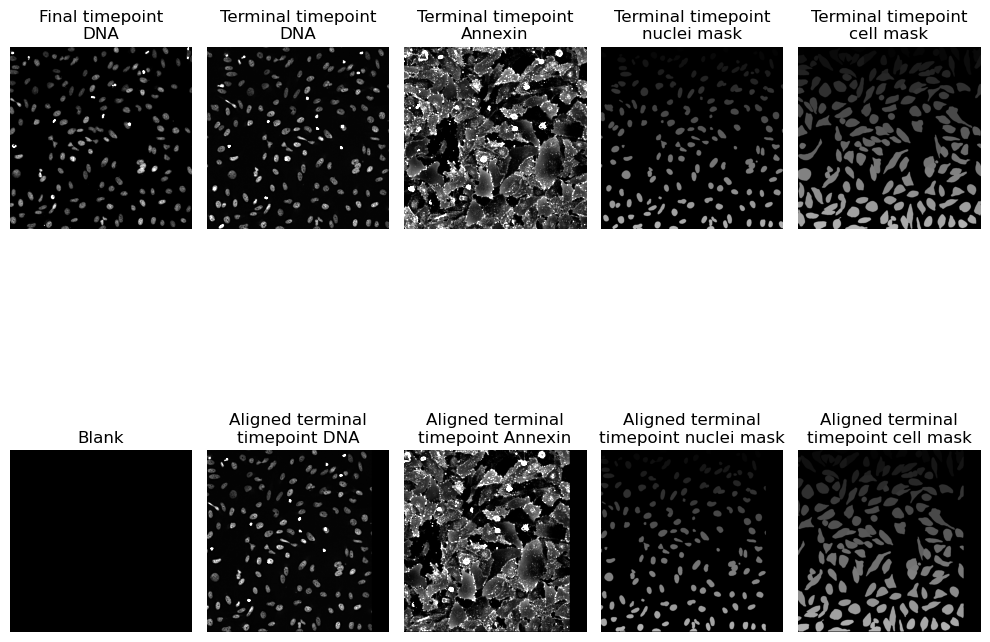

In [7]:
if in_notebook:
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 5, 1)
    plt.imshow(final_timepoint_dna, cmap="gray", vmin=0, vmax=255)
    plt.title("Final timepoint\nDNA")
    plt.axis("off")
    plt.subplot(2, 5, 2)
    plt.imshow(terminal_timepoint_dna, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\nDNA")
    plt.axis("off")
    plt.subplot(2, 5, 3)
    plt.imshow(terminal_timepoint_annexin, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\nAnnexin")
    plt.axis("off")
    plt.subplot(2, 5, 4)
    plt.imshow(terminal_timepoint_nuclei_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\nnuclei mask")
    plt.axis("off")
    plt.subplot(2, 5, 5)
    plt.imshow(terminal_timepoint_cell_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\ncell mask")
    plt.axis("off")
    plt.subplot(2, 5, 6)
    plt.imshow(np.zeros_like(final_timepoint_dna), cmap="gray", vmin=0, vmax=255)
    plt.title("Blank")
    plt.axis("off")
    plt.subplot(2, 5, 7)
    plt.imshow(aligned_terminal_timepoint_dna, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint DNA")
    plt.axis("off")
    plt.subplot(2, 5, 8)
    plt.imshow(aligned_terminal_timepoint_annexin, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint Annexin")
    plt.axis("off")
    plt.subplot(2, 5, 9)
    plt.imshow(aligned_terminal_timepoint_nuclei_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint nuclei mask")
    plt.axis("off")
    plt.subplot(2, 5, 10)
    plt.imshow(aligned_terminal_timepoint_cell_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint cell mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()